In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
#load data
train = pd.read_csv("sales_train.csv")
test = pd.read_csv("test.csv")
item_catigories = pd.read_csv('items.csv')
catigories = pd.read_csv('item_categories.csv')


In [3]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [4]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [5]:
test.columns

Index(['ID', 'shop_id', 'item_id'], dtype='object')

In [6]:
test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,214200.0,107099.500000,61834.358168,0.0,53549.75,107099.5,160649.25,214199.0
shop_id,214200.0,31.642857,17.561933,2.0,16.00,34.5,47.00,59.0
item_id,214200.0,11019.398627,6252.644590,30.0,5381.50,11203.0,16071.50,22167.0


In [7]:
item_catigories.columns

Index(['item_name', 'item_id', 'item_category_id'], dtype='object')

In [8]:
item_catigories.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
item_id,22170.0,11084.500000,6400.072070,0.0,5542.25,11084.5,16626.75,22169.0
item_category_id,22170.0,46.290753,15.941486,0.0,37.00,40.0,58.00,83.0


In [9]:
catigories.columns

Index(['item_category_name', 'item_category_id'], dtype='object')

In [10]:
catigories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


(array([2.935834e+06, 1.300000e+01, 1.000000e+00, 0.000000e+00,
        1.000000e+00]),
 array([ -22. ,  416.2,  854.4, 1292.6, 1730.8, 2169. ]),
 <a list of 5 Patch objects>)

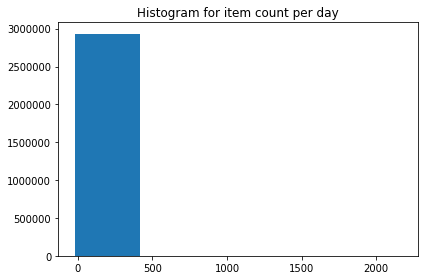

In [11]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

plt.title('Histogram for item count per day')
axs.hist(train['item_cnt_day'], bins=5)


In [12]:
train = train.loc[(train.item_cnt_day < 669)]

# train.date = train.date.apply(lambda x:dt.datetime.strptime(x, '%d.%m.%Y'))
# train.date = train.date.apply(lambda x:dt.datetime.strftime(x,'%Y-%m'))

In [43]:
data = train.groupby(['date_block_num','item_id','shop_id']).sum().reset_index()
# print(data)
data = data[['date_block_num','item_id','shop_id','item_cnt_day','item_price']]
item_catigories = item_catigories[['item_id','item_category_id']]

# data.head(10)

table = pd.pivot_table(data, values='item_cnt_day', index=['item_id', 'shop_id'],
                        columns=['date_block_num'], aggfunc=np.sum).reset_index()

table = table.fillna(0)

# data_form = table
data_form = item_catigories.merge(table, on = ['item_id'], how = 'inner')

pd.merge(data_form,test, on = ['item_id'], how = 'left')

data_form = data_form.fillna(0)
data_form.describe()



,item_id,item_category_id,shop_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
count,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,...,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000
mean,11458.020213,42.604012,31.431223,0.310001,0.302011,0.346932,0.252733,0.252214,0.295623,0.275783,...,0.259290,0.198522,0.193373,0.183501,0.170457,0.151168,0.148982,0.155801,0.170172,0.162422
std,6133.332458,15.219469,16.962064,1.511665,1.599241,2.051992,1.360014,2.010463,3.319192,2.737078,...,3.435255,1.528047,1.492460,3.579918,2.840769,1.699408,1.577261,1.597581,4.480228,2.025278
min,0.000000,0.000000,0.000000,-13.000000,-4.000000,-2.000000,-2.000000,-1.000000,-1.000000,-2.000000,...,-2.000000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.000000
25%,6244.000000,37.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11614.000000,40.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16662.000000,55.000000,46.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,22169.000000,83.000000,59.000000,169.000000,130.000000,259.000000,175.000000,504.000000,766.000000,799.000000,...,1127.000000,300.000000,291.000000,1242.000000,742.000000,444.000000,482.000000,436.000000,1644.000000,500.000000


In [14]:
data.loc[(data['date_block_num'] > 1) & (data['shop_id'] == 2) & (data['item_id'] == 31)] 

,date_block_num,item_id,shop_id,item_cnt_day,item_price
123212,2,31,2,1.0,698.50
187177,3,31,2,1.0,699.00
882793,16,31,2,1.0,415.92
1577593,33,31,2,1.0,399.00


In [15]:
data_form.loc[(data_form['shop_id'] == 2) & (data_form['item_id'] == 31)] 

,item_id,item_category_id,shop_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
154,31,37,2,0.0,4.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
data_form.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
item_id,424124.0,11458.020213,6133.332458,0.0,6244.0,11614.0,16662.0,22169.0
item_category_id,424124.0,42.604012,15.219469,0.0,37.0,40.0,55.0,83.0
shop_id,424124.0,31.431223,16.962064,0.0,18.0,30.0,46.0,59.0
0,424124.0,0.310001,1.511665,-13.0,0.0,0.0,0.0,169.0
1,424124.0,0.302011,1.599241,-4.0,0.0,0.0,0.0,130.0
2,424124.0,0.346932,2.051992,-2.0,0.0,0.0,0.0,259.0
3,424124.0,0.252733,1.360014,-2.0,0.0,0.0,0.0,175.0
4,424124.0,0.252214,2.010463,-1.0,0.0,0.0,0.0,504.0
5,424124.0,0.295623,3.319192,-1.0,0.0,0.0,0.0,766.0
6,424124.0,0.275783,2.737078,-2.0,0.0,0.0,0.0,799.0


In [17]:
data_form.columns

Index([         'item_id', 'item_category_id',          'shop_id',
                        0,                  1,                  2,
                        3,                  4,                  5,
                        6,                  7,                  8,
                        9,                 10,                 11,
                       12,                 13,                 14,
                       15,                 16,                 17,
                       18,                 19,                 20,
                       21,                 22,                 23,
                       24,                 25,                 26,
                       27,                 28,                 29,
                       30,                 31,                 32,
                       33],
      dtype='object')

In [18]:
# faad = data_from.loc[(data['date_block_num'] > 32) & (data['shop_id'] == 2)] 
# print(faad)

In [19]:
data_form.shape

(424124, 37)

In [20]:
guess_and_check = data_form
guess_and_check = guess_and_check.loc[guess_and_check['shop_id'] == 27]
guess_and_check = guess_and_check.loc[guess_and_check['item_id'] == 3423]
check_vals = guess_and_check.drop(columns=['shop_id','item_id','item_category_id']).T
print(check_vals.shape)
guess_and_check

(34, 1)


,item_id,item_category_id,shop_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
53934,3423,23,27,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,4.0,3.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0


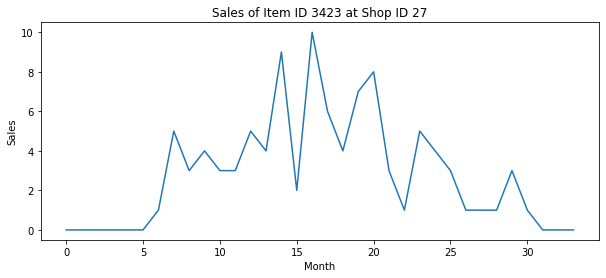

In [21]:
plt.figure(figsize =(10,4))
plt.title('Sales of Item ID 3423 at Shop ID 27')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.plot(guess_and_check.columns[3:],check_vals)

In [22]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(data_form.values.T)
dataset = dataset.T

In [23]:
print(dataset.shape)

(424124, 37)


In [24]:
X1, y1 = dataset[:,:36], dataset[:,36:37]
print(X1.shape)
print(y1.shape)


(424124, 36)
(424124, 1)


In [25]:
x_train, x_test, y_train, y_test = train_test_split(X1,y1,test_size=0.3,random_state=0)


x_train= x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

print(x_train.shape)
print(x_test.shape)

(296886, 1, 36)
(127238, 1, 36)


In [44]:
batch_size = 358#895#1660
def model_neural(): 
    model = Sequential()
    model.add(LSTM(32, return_sequences = True , input_shape=(x_train.shape[1], x_train.shape[2]),
                   stateful = False))
    model.add(LSTM(64, return_sequences = True,stateful = False))
    model.add(LSTM(128, return_sequences = False,stateful = False))
    model.add(Dense(1))
    opt = optimizers.RMSprop()
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])

    return model

model1 = model_neural()

#record training time
start=time.time()
training_model=model1.fit(x_train, y_train, validation_data = (x_test,y_test), batch_size = 358, epochs = 8, shuffle=False)
end=time.time()
print("--------------------------")
print("Total training time (seconds)", end-start)

# make predictions
trainPredict = model1.predict(x_train, batch_size = 358)
testPredict = model1.predict(x_test, batch_size = 358)

#test error
test_rmse = model1.evaluate(x_test, y_test,batch_size = 358)
print("--------------------------")
print('RMSE' , test_rmse[0])

Train on 296886 samples, validate on 127238 samples
Epoch 1/8
296886/296886 [==============================] - 29s 98us/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 2/8
296886/296886 [==============================] - 26s 89us/step - loss: 9.2930e-04 - mean_squared_error: 9.2930e-04 - val_loss: 6.4136e-04 - val_mean_squared_error: 6.4136e-04
Epoch 3/8
296886/296886 [==============================] - 27s 92us/step - loss: 5.2640e-04 - mean_squared_error: 5.2640e-04 - val_loss: 4.0622e-04 - val_mean_squared_error: 4.0622e-04
Epoch 4/8
296886/296886 [==============================] - 27s 92us/step - loss: 3.5767e-04 - mean_squared_error: 3.5767e-04 - val_loss: 2.9033e-04 - val_mean_squared_error: 2.9033e-04
Epoch 5/8
296886/296886 [==============================] - 27s 90us/step - loss: 2.6825e-04 - mean_squared_error: 2.6825e-04 - val_loss: 2.2487e-04 - val_mean_squared_error: 2.2487e-04
Epoch 6/8
296886/296886 [==============

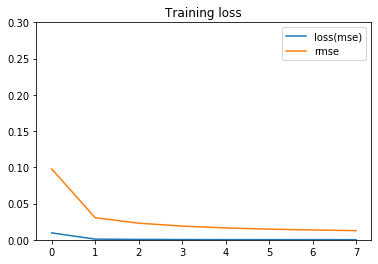

In [45]:
plt.plot(training_model.history['loss'], label= 'loss(mse)')
plt.plot(np.sqrt(training_model.history['mean_squared_error']), label= 'rmse')
plt.title('Training loss')
plt.ylim(0,0.3)
plt.legend(loc=1)
plt.show()

254476